## MDS Thesis
#### 06. Benchmark GELECTRA prediction results with ED8 dictionary

<br>
<hr style="opacity: 0.5">

### Setup

In [42]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr

In [43]:
# set wd
ROOT_DIR = "/Users/varvarailyina/hertie/mds_thesis/data"

In [77]:
# load sentence-level data
df_ed8 = pd.read_csv(os.path.join(ROOT_DIR, "out", "df_res_ed8.csv"))
df_gelectra = pd.read_pickle(os.path.join(ROOT_DIR, "out", "df_all.pkl"))

-- *Prepare merged GELECTRA + ED8 data*

In [75]:
# define emotion labels
emotions = ['anger', 'fear', 'disgust', 'sadness', 'joy', 'enthusiasm', 'pride', 'hope']

# rename columns for clarity
df_ed8 = df_ed8.rename(columns={f'ed8_{emo}': emo for emo in emotions})
df_ed8 = df_ed8.rename(columns={f'ed8_{emo}_norm': f'ed8_{emo}' for emo in emotions})

df_gelectra = df_gelectra.rename(columns={f'{emo}': f'gelectra_{emo}' for emo in emotions})

In [76]:
# check col names
print(df_ed8.columns)
print(df_gelectra.columns)

Index(['Unnamed: 0', 'doc_id', 'party', 'date', 'month', 'text', 'sentence',
       'anger', 'fear', 'disgust', 'sadness', 'joy', 'enthusiasm', 'pride',
       'hope', 'terms_raw', 'terms', 'ed8_anger', 'ed8_fear', 'ed8_disgust',
       'ed8_sadness', 'ed8_joy', 'ed8_enthusiasm', 'ed8_pride', 'ed8_hope'],
      dtype='object')
Index(['country_name', 'party', 'party_name', 'family_name', 'date', 'month',
       'calendar_week', 'issue_mono', 'issue_label', 'header', 'text',
       'n_words', 'doc_id', 'sentence', 'gelectra_anger', 'gelectra_fear',
       'gelectra_disgust', 'gelectra_sadness', 'gelectra_joy',
       'gelectra_enthusiasm', 'gelectra_pride', 'gelectra_hope'],
      dtype='object')


-- *Merge results*

In [50]:
# subset ED8
df_ed8_sub = df_ed8[['date', 'text', 'sentence'] + [f'ed8_{emo}' for emo in emotions]]

# subset GELECTRA
df_gelectra_sub = df_gelectra[['party', 'date', 'issue_mono', 'issue_label', 'doc_id', 'text', 'sentence'] + [f'gelectra_{emo}' for emo in emotions]]

In [52]:
# merge on shared keys
df_merged = pd.merge(
    df_gelectra_sub,
    df_ed8_sub,
    on=['date', 'text', 'sentence'],
    how='inner'
)

# check merge success
print(f"Merged dataset has {df_merged.shape[0]} rows.")

Merged dataset has 453410 rows.


<hr style="opacity: 0.25">

### Correlate GELECTRA vs. ED8 predictions

-- *Correlate overall sentence-level predictions*

In [73]:
# sentence-level correlation

# initialize results
correlations = []

# loop through emotions
for emo in emotions:
    #col_ed8 = f'ed8_{emo}_norm'
    #col_gelectra = f'gelectra_{emo}_norm'
    col_ed8 = f'ed8_{emo}'
    col_gelectra = f'gelectra_{emo}'

    # drop NA values before correlation
    valid_data = df_merged[[col_ed8, col_gelectra]].dropna()

    if len(valid_data) >= 10:
        corr, pval = pearsonr(valid_data[col_ed8], valid_data[col_gelectra])
        correlations.append({
            'emotion': emo,
            'correlation': round(corr, 4),
            'p_value': pval
        })
    else:
        correlations.append({
            'emotion': emo,
            'correlation': None,
            'p_value': None
        })

# df of results
df_correlations = pd.DataFrame(correlations)

# output corr table
print("\nEmotion Correlations between ED8 and GELECTRA:")
print(df_correlations)


Emotion Correlations between ED8 and GELECTRA:
      emotion  correlation  p_value
0       anger       0.1960      0.0
1        fear       0.3730      0.0
2     disgust       0.3610      0.0
3     sadness       0.3229      0.0
4         joy       0.2623      0.0
5  enthusiasm       0.2853      0.0
6       pride       0.1742      0.0
7        hope       0.2122      0.0


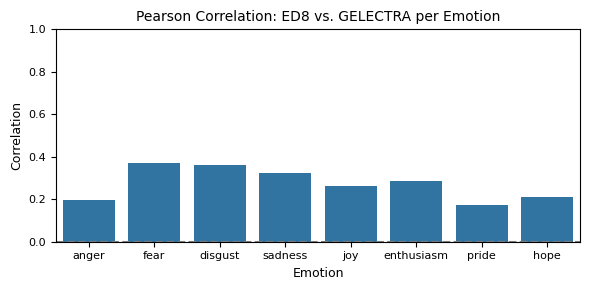

In [72]:
# plot
plt.figure(figsize=(6, 3))

sns.barplot(data=df_correlations, x='emotion', y='correlation')

plt.title('Pearson Correlation: ED8 vs. GELECTRA per Emotion', fontsize=10)
plt.xlabel("Emotion", fontsize=9)
plt.ylabel("Correlation", fontsize=9)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylim(0, 1)
plt.axhline(0, linestyle='--', color='gray')

plt.tight_layout()
plt.show()

-- *ED8 and GELECTRA alignment..*

In [78]:
def group_correlation(df, group_col, emotions, label):
    print(f"\nCorrelations by {label.title()}")

    # group and average by the grouping column (e.g., party, month)
    df_grouped = df.groupby(group_col).mean(numeric_only=True)

    rows = []

    for emo in emotions:
        col_ed8 = f'ed8_{emo}'
        col_gelectra = f'gelectra_{emo}'

        if col_ed8 in df_grouped.columns and col_gelectra in df_grouped.columns:
            x = df_grouped[col_ed8]
            y = df_grouped[col_gelectra]

            if len(x) >= 3:  # at least 3 points to correlate
                corr, pval = pearsonr(x, y)
                rows.append({
                    'emotion': emo,
                    'correlation': round(corr, 3),
                    'p_value': f"{pval:.2e}"
                })

    return pd.DataFrame(rows)

*..aggregated by party*

In [79]:
# corr by party
df_party_corr = group_correlation(df_merged, 'party', emotions, 'party')
print(df_party_corr)

# whether gelectra and ed8 agree on which parties express more / less of each emotion on average


Correlations by Party
      emotion  correlation   p_value
0       anger        0.963  2.00e-03
1        fear        0.981  5.37e-04
2     disgust        0.957  2.79e-03
3     sadness        0.955  3.02e-03
4         joy        0.982  4.58e-04
5  enthusiasm        0.935  6.21e-03
6       pride        0.967  1.62e-03
7        hope        0.995  3.99e-05


*..by issue*

In [80]:
# corr by issue
df_issue_corr  = group_correlation(df_merged, 'issue_mono', emotions, 'issue')
print(df_issue_corr)

# whether gelectra and ed8 agree on which issues associated with higher / lower levels of emotion on average


Correlations by Issue
      emotion  correlation   p_value
0       anger        0.662  1.09e-03
1        fear        0.899  2.95e-08
2     disgust        0.933  6.80e-10
3     sadness        0.942  1.82e-10
4         joy        0.524  1.47e-02
5  enthusiasm        0.877  1.85e-07
6       pride        0.823  4.63e-06
7        hope        0.591  4.76e-03


*..by month*

In [81]:
# create month variable
df_merged['month'] = pd.to_datetime(df_merged['date']).dt.strftime('%y%m')

# by month
df_month_corr = group_correlation(df_merged, 'month', emotions, 'month')
print(df_month_corr)

# whether gelectra and ed8 classify similar emotion sores per month across all sentences


Correlations by Month
      emotion  correlation   p_value
0       anger        0.483  4.70e-08
1        fear        0.809  7.09e-28
2     disgust        0.721  9.94e-20
3     sadness        0.695  6.50e-18
4         joy        0.450  4.58e-07
5  enthusiasm        0.749  5.82e-22
6       pride        0.515  3.86e-09
7        hope        0.620  1.42e-13


*..by party on sentence-level*

In [82]:
# per party without averaging

results = []

for party in df_merged['party'].unique():
    subset = df_merged[df_merged['party'] == party]
    for emo in emotions:
        col_ed8 = f'ed8_{emo}'
        col_gelectra = f'gelectra_{emo}'
        valid = subset[[col_ed8, col_gelectra]].dropna()
        if len(valid) >= 10:
            corr, pval = pearsonr(valid[col_ed8], valid[col_gelectra])
            results.append({
                'party': party,
                'emotion': emo,
                'correlation': round(corr, 3),
                'p_value': pval
            })

df_party_sentence_corr = pd.DataFrame(results)
print(df_party_sentence_corr)

      party     emotion  correlation        p_value
0       FDP       anger        0.194   0.000000e+00
1       FDP        fear        0.359   0.000000e+00
2       FDP     disgust        0.324   0.000000e+00
3       FDP     sadness        0.301   0.000000e+00
4       FDP         joy        0.259   0.000000e+00
5       FDP  enthusiasm        0.274   0.000000e+00
6       FDP       pride        0.161  5.973454e-307
7       FDP        hope        0.218   0.000000e+00
8       SPD       anger        0.179   0.000000e+00
9       SPD        fear        0.372   0.000000e+00
10      SPD     disgust        0.346   0.000000e+00
11      SPD     sadness        0.320   0.000000e+00
12      SPD         joy        0.256   0.000000e+00
13      SPD  enthusiasm        0.310   0.000000e+00
14      SPD       pride        0.169   0.000000e+00
15      SPD        hope        0.221   0.000000e+00
16   Greens       anger        0.158   0.000000e+00
17   Greens        fear        0.370   0.000000e+00
18   Greens 